## EC61409 NEURAL NETWORKS
### Assignment 5: Autoencoders

#### Name: Shikhar Mohan
#### Roll No.: 18EC10054
#### Date: 01/11/2021

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

In [2]:
batch_size = 512
epochs = 20
learning_rate = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataset = torchvision.datasets.MNIST(root="~/torch_datasets", train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# First given AE model

class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features, hidden=False):
        activation = self.encoder_hidden_layer(features.view(-1,784))
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.sigmoid(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.sigmoid(activation)
        
        if hidden is False:
            return reconstructed
        
        return reconstructed, code

In [5]:
# Second modified AE model

class myAE(nn.Module):
    def __init__(self, in_shape):
        super().__init__()
        self.conv1 = nn.Conv2d(1,4,3,2)
        self.encoder = nn.Sequential(nn.Linear(4*13*13,128),
                                     nn.ReLU(),
                                     nn.Linear(128,128),
                                     nn.ReLU(),
                                     nn.Linear(128,25)
                                     )
        self.decoder = nn.Sequential(nn.Linear(25,128),
                                     nn.ReLU(),
                                     nn.Linear(128,128),
                                     nn.ReLU(),
                                     nn.Linear(128,in_shape)
                                     )

    def forward(self, features, hidden=False):
        features = self.conv1(features)
        code = self.encoder(features.view(-1,4*13*13))
        code = torch.sigmoid(code)
        activation = self.decoder(code)
        reconstructed = torch.sigmoid(activation)
        
        if hidden is False:
            return reconstructed
        
        return reconstructed, code

In [6]:
class Trainer:
    def __init__(self, model, train_loader, test_loader, learning_rate, hidden_states, criterion=nn.MSELoss(), device = 'cuda:0'):
        self.model = model
        self.epochs = epochs
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion = criterion
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.device = device
        self.hidden_states = hidden_states

    def train(self, epochs):
        loss_trend = []
        for epoch in range(epochs):
            loss = 0
            for batch_features, _ in tqdm(self.train_loader):
                # load it to the active device
                batch_features = batch_features.to(self.device)
                self.optimizer.zero_grad()
                
                # compute reconstructions
                outputs = self.model(batch_features)
                train_loss = self.criterion(outputs, batch_features.view(-1,784))
                train_loss.backward()
                
                self.optimizer.step()
                loss_trend.append(train_loss.item())

            loss = sum(loss_trend) / len(loss_trend)
            
            # display the epoch training loss
            print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

    def evaluate(self, n_images):
        with torch.no_grad():
            for batch_features in self.test_loader:
                batch_features = batch_features[0]
                test_examples = batch_features.to(self.device)
                reconstruction, code = self.model(test_examples, hidden=True)
                break

        number = n_images
        plt.figure(figsize=(10, 4))
        for index in range(number):
            # display original
            ax = plt.subplot(3, number, index + 1)
            plt.imshow(test_examples[index].cpu().numpy().reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(3, number, index + 1 + number)
            plt.imshow(reconstruction[index].cpu().numpy().reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display hidden layer
            ax = plt.subplot(3, number, index + 1 + 2*number)
            plt.imshow(np.concatenate([code[0].cpu().numpy().reshape((1,self.hidden_states)) for i in range(self.hidden_states//5)]))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

In [8]:
model1 = AE(input_shape=784).to(device)
trainer1 = Trainer(model1, train_loader, test_loader, learning_rate, 128)
model2 = myAE(in_shape=784).to(device)
trainer2 = Trainer(model2, train_loader, test_loader, learning_rate, 25)

In [9]:
trainer1.train(epochs)
print("*********\nModel 1 finished training.\n*********")
trainer2.train(epochs)
print("*********\nModel 2 finished training.\n*********")

  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 1/20, recon loss = 0.08434185


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 2/20, recon loss = 0.07312819


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 3/20, recon loss = 0.06802624


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 4/20, recon loss = 0.06389201


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 5/20, recon loss = 0.05999431


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 6/20, recon loss = 0.05657960


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 7/20, recon loss = 0.05374223


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 8/20, recon loss = 0.05127799


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 9/20, recon loss = 0.04909962


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 10/20, recon loss = 0.04715526


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 11/20, recon loss = 0.04540437


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 12/20, recon loss = 0.04376457


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 13/20, recon loss = 0.04227205


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 14/20, recon loss = 0.04091118


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 15/20, recon loss = 0.03967065


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 16/20, recon loss = 0.03851567


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 17/20, recon loss = 0.03744097


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 18/20, recon loss = 0.03645245


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 19/20, recon loss = 0.03553077


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 20/20, recon loss = 0.03466492
Model 1 finished training.


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 1/20, recon loss = 0.09096387


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 2/20, recon loss = 0.07913959


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 3/20, recon loss = 0.07456457


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 4/20, recon loss = 0.07109367


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 5/20, recon loss = 0.06882646


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 6/20, recon loss = 0.06714353


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 7/20, recon loss = 0.06548259


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 8/20, recon loss = 0.06374788


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 9/20, recon loss = 0.06177423


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 10/20, recon loss = 0.05961522


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 11/20, recon loss = 0.05734317


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 12/20, recon loss = 0.05525366


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 13/20, recon loss = 0.05332774


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 14/20, recon loss = 0.05152806


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 15/20, recon loss = 0.04988433


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 16/20, recon loss = 0.04838595


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 17/20, recon loss = 0.04700678


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 18/20, recon loss = 0.04573506


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 19/20, recon loss = 0.04456665


  0%|          | 0/117 [00:00<?, ?it/s]

epoch : 20/20, recon loss = 0.04349040
Model 2 finished training.


Five images from model 1


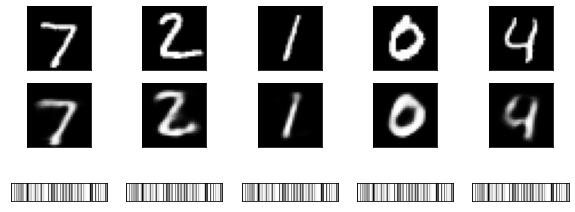

Two images from model 2


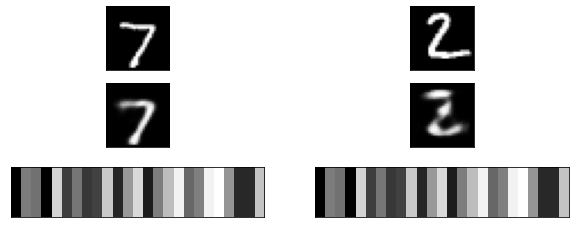

In [10]:
print("Five images from model 1")
trainer1.evaluate(5)
print("Two images from model 2")
trainer2.evaluate(2)